## Data

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
cid = '#cid'
secret = '#secret'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [78]:
def factorDimensions(total):
    x1, x2, i = 1, total, 0
    while x1 < x2:
        i += 1
        if total % i == 0:
            x1 = i
            x2 = total//x1
    return (x2, x1)

In [57]:
song_colors = pd.read_csv('song-color.csv', engine='python')
song_colors.head()

,songName,songArtist,spotifyURI,r,g,b,albumName
0,1 2 365 4 Me,Kennen,spotify:track:6TtDPG6eFqDGooeyKYXaea,213,0,50,NaN
1,Suzanne,Bermuda Triangle,spotify:track:3MBZ0BaWosUjsn40TeYYk5,254,243,128,NaN
2,Trace,Micah Marcos,spotify:track:1CXeNAaiWBBOkpstvC8WJp,250,222,133,NaN
3,Hey There Delilah,Plain White T's,spotify:track:4RCWB3V8V0dignt99LZ8vH,255,214,98,NaN
4,???,Yuma Yamaguchi,spotify:track:3quI9fle27boUZXStQKtxy,254,219,0,NaN


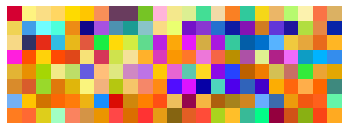

In [58]:
colors = np.array(song_colors[['r','g','b']])
indices = np.array(range(len(colors)))
indices.shape = factorDimensions(len(colors))

plt.imshow(colors[indices])
plt.axis("off")
plt.savefig("figures/colors.png")

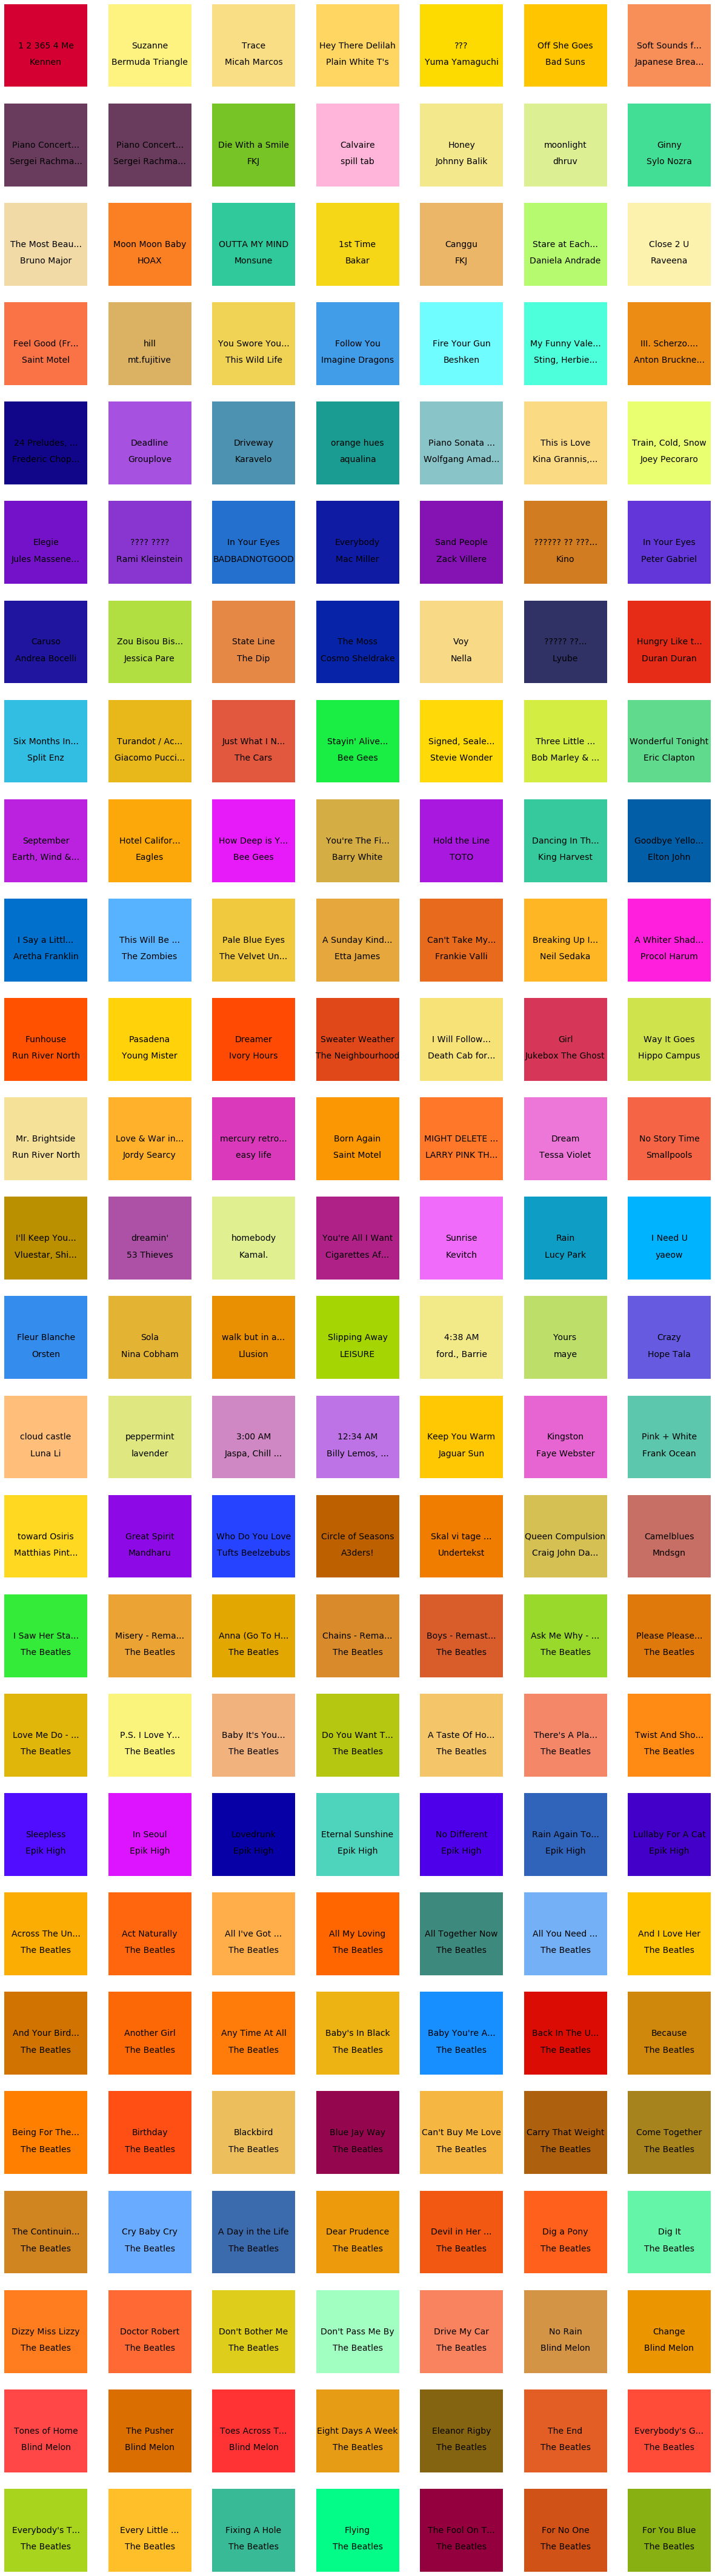

In [10]:
cols = 7
rows = len(colors)//cols

fig, ax = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
i=0

total_length = 17
abridged_length = total_length - 4

for row in ax:
    for col in row:
        col.imshow(np.array([[[song_colors['r'][i], song_colors['g'][i], song_colors['b'][i]]]]))
        col.axis('off')
        
        if len(song_colors['songName'][i]) > total_length:
            col.set_xlabel(song_colors['songName'][i][:abridged_length] + '...')
            col.text(0, 0, song_colors['songName'][i][:abridged_length] + '...',
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=14)
        else:
            col.text(0, 0, song_colors['songName'][i],
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=14)
            
        if len(song_colors['songArtist'][i]) > total_length:
            col.text(0, 0.2, song_colors['songArtist'][i][:abridged_length] + '...',
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=14)
        else:      
            col.text(0, 0.2, song_colors['songArtist'][i],
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=14)
        
        col.set_aspect('equal')
        i+=1

plt.savefig("figures/song_colors.png")

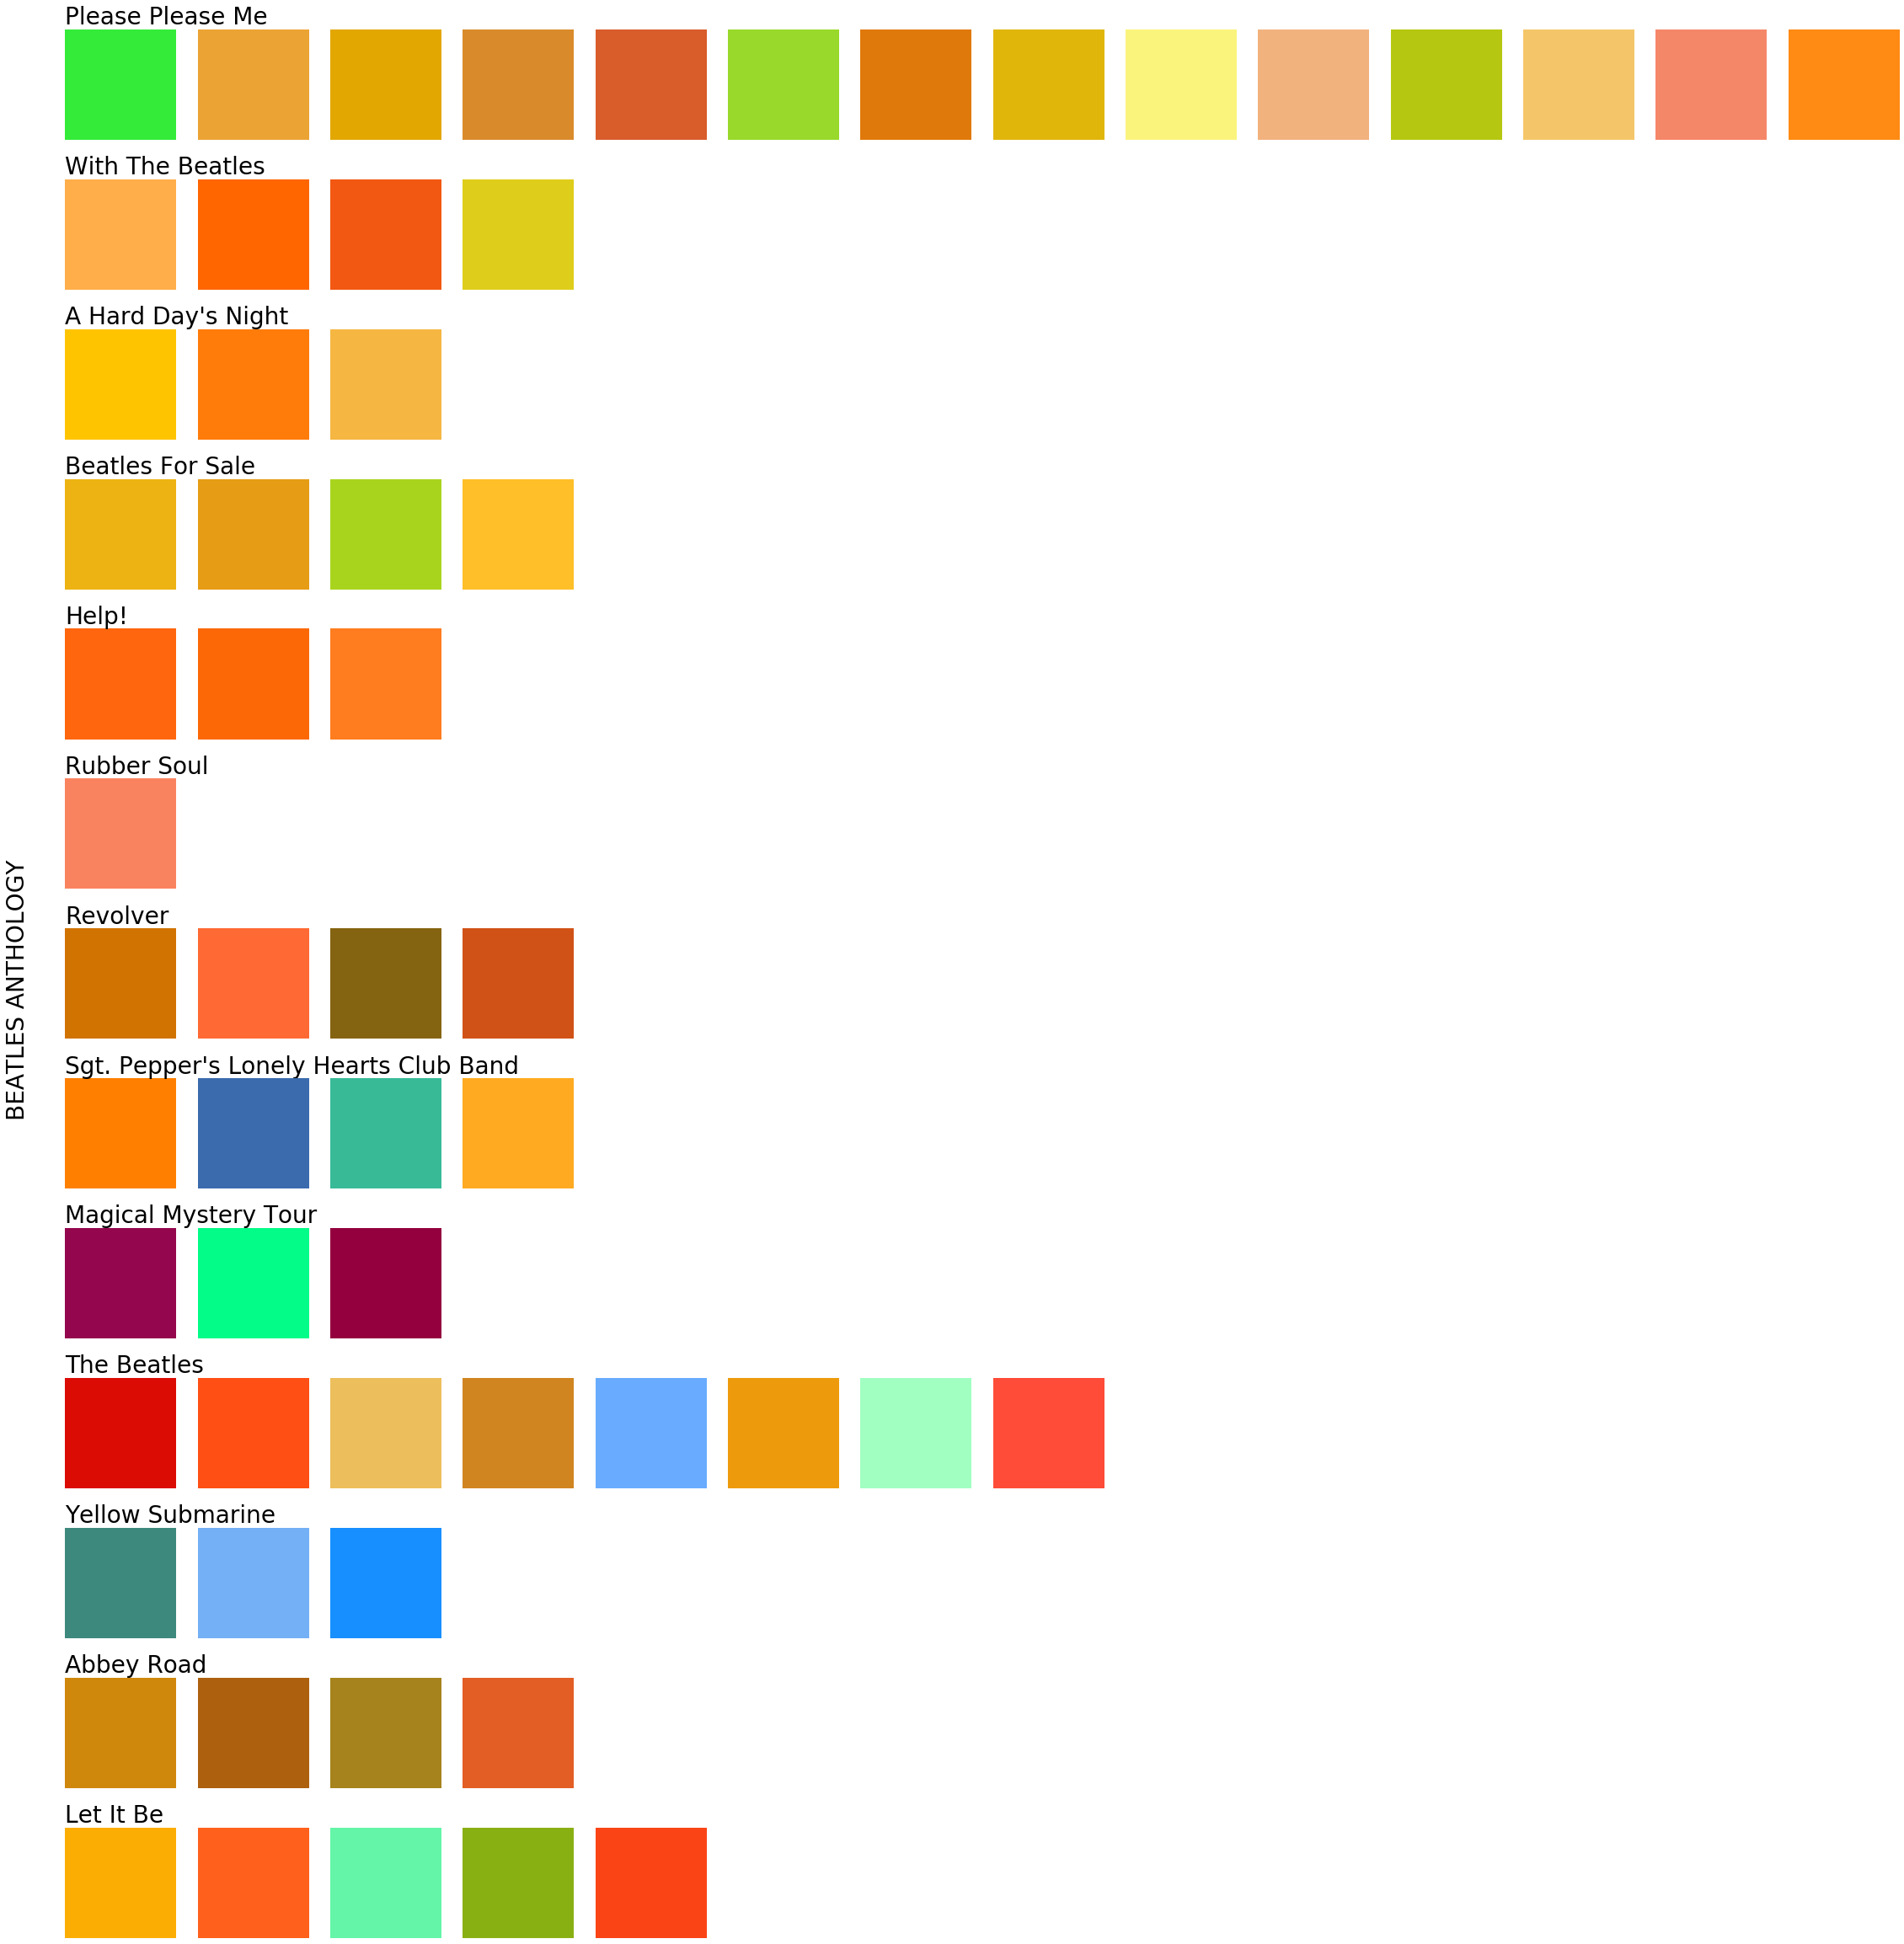

In [207]:
beatles = song_colors[song_colors['songArtist'] == 'The Beatles']
beatlesOrder = ['Please Please Me', 'With The Beatles', 'A Hard Day\'s Night', 'Beatles For Sale',
                    'Help!', 'Rubber Soul', 'Revolver', 'Sgt. Pepper\'s Lonely Hearts Club Band',
                    'Magical Mystery Tour', 'The Beatles', 'Yellow Submarine', 'Abbey Road', 'Let It Be']

def normalizeAlbums(songs, albumOrder):
    column_names = ['songName', 'songArtist', 'spotifyURI', 'r', 'g', 'b', 'albumName']
    max_songs = max(songs['albumName'].value_counts())
    
    normalized_songs = pd.DataFrame(columns=column_names)
    for album in albumOrder:
        normalized_songs = normalized_songs.append(songs[songs['albumName'] == album])
        album_length = len(songs[songs['albumName'] == album].index)
        if album_length < max_songs:
            normalized_album = np.tile(np.array(['','','',255,255,255,album]), (max_songs - album_length, 1))
            normalized_songs = normalized_songs.append(pd.DataFrame(normalized_album,
                                              columns=column_names))
    
    normalized_songs[['r', 'g', 'b']] = normalized_songs[['r', 'g', 'b']].apply(pd.to_numeric, axis=1) 
    normalized_songs = normalized_songs.reset_index(drop=True)
    
    return normalized_songs
            


def plotAlbumColor(colors, albumOrder, savePath):

    colors = normalizeAlbums(colors, albumOrder)
    
    rows = len(albumOrder)
    cols = int(len(colors.index)/rows)    

    fig, ax = plt.subplots(rows, cols, sharey=True, figsize=(rows*3, cols*3))
    i=0
    
    for row in ax:
            for col in row:
                col.imshow(np.array([[[colors['r'][i], colors['g'][i], colors['b'][i]]]]))
                col.axis('off')
                if i%cols == 0:
                    col.set_title(colors['albumName'][i], fontsize=28, loc='left')
                i+=1

    fig.text(0.1, 0.5, 'BEATLES ANTHOLOGY', va='center', rotation='vertical', fontsize=28)
    plt.savefig(savePath)
    plt.show()
    
plotAlbumColor(beatles, beatlesOrder, 'figures/beatles_colors.png')

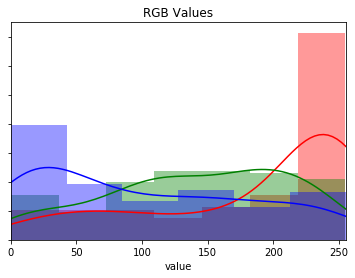

In [11]:
color_columns = ['r', 'g', 'b']


for color in color_columns:
    ax = sns.distplot(song_colors[color], color = color)
    ax.set_xlim([0, 255])
    ax.set_yticklabels([])
    ax.set(xlabel='value', title='RGB Values')

plt.savefig("figures/color_dist.png")

In [12]:
danceability = []
energy = []
key = []
loudness = []
mode = []
speechiness = []
acousticness = []
instrumentalness = []
liveness = []
valence = []
tempo = []
duration_ms = []
time_signature = []

In [13]:
trackURIs = np.array(song_colors['spotifyURI'])

for i in range(len(trackURIs)):
    features = sp.audio_features(tracks=[trackURIs[i]])

    danceability = np.append(danceability, features[0]['danceability'])
    energy = np.append(energy, features[0]['energy'])
    key = np.append(key, features[0]['key'])
    loudness = np.append(loudness, features[0]['loudness'])
    mode = np.append(mode, features[0]['mode'])
    speechiness = np.append(speechiness, features[0]['speechiness'])
    acousticness = np.append(acousticness, features[0]['acousticness'])
    instrumentalness = np.append(instrumentalness, features[0]['instrumentalness'])
    liveness = np.append(liveness, features[0]['liveness'])
    valence = np.append(valence, features[0]['valence'])
    tempo = np.append(tempo, features[0]['tempo'])
    duration_ms = np.append(duration_ms, features[0]['duration_ms'])
    time_signature = np.append(time_signature, features[0]['time_signature'])

In [14]:
audio_features = pd.DataFrame({'danceability' : danceability, 'energy' : energy, 'key' : key, "loudness" : loudness,
                           'mode' : mode, "speechiness" : speechiness, "acousticness" : acousticness,
                            "instrumentalness" : instrumentalness, "liveness" : liveness, "valence" : valence,
                           "tempo" : tempo, "duration_ms" : duration_ms, "time_signature" : time_signature})

audio_features.to_csv("audio_features.csv")
audio_features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.621,0.744,6.0,-5.881,1.0,0.0480,0.111,0.000005,0.3330,0.741,139.979,174857.0,4.0
1,0.799,0.480,9.0,-9.839,1.0,0.0690,0.533,0.015800,0.1310,0.635,113.428,177704.0,4.0
2,0.795,0.462,1.0,-11.212,0.0,0.0658,0.795,0.000006,0.1100,0.626,134.998,171928.0,4.0
3,0.656,0.291,2.0,-10.572,1.0,0.0293,0.872,0.000000,0.1140,0.298,103.971,232533.0,4.0
4,0.870,0.330,5.0,-12.329,1.0,0.0373,0.923,0.085000,0.0949,0.542,114.885,111000.0,4.0


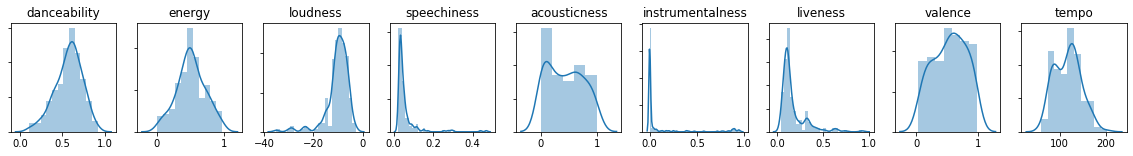

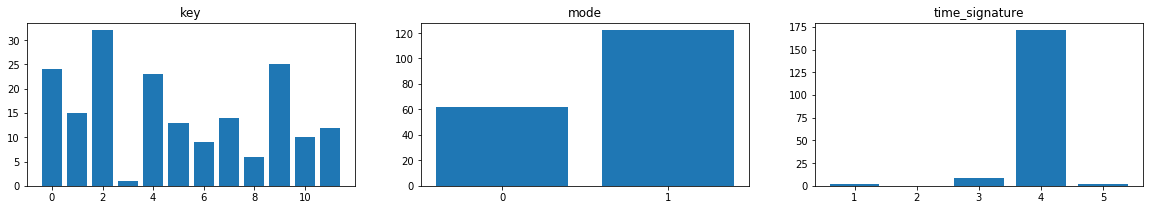

In [15]:
cont_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                'valence', 'tempo']
disc_columns = ['key', 'mode', 'time_signature']

f, axs = plt.subplots(1, 9, figsize=(20, 2))
for i in range(len(cont_columns)):
    sns.distplot(audio_features[cont_columns[i]], ax=axs[i])
    axs[i].set_yticklabels([])
    axs[i].set_xlabel(None)
    axs[i].set_title(cont_columns[i])

plt.savefig("figures/features_hist.png")
    

g, axs = plt.subplots(1, 3, figsize=(20, 3))
for i in range(len(disc_columns)):
    freq = audio_features[disc_columns[i]].value_counts().sort_index()
    axs[i].set_title(disc_columns[i])
    
    if disc_columns[i] == 'mode':
        axs[i].bar(list(map(str, map(int, freq.index))), freq.values)
    else:
        axs[i].bar(freq.index, freq.values)

plt.savefig("figures/features_bar.png")

## Model